# MCMC Exploration

Simple line regression with a Monte Carlo Markov Chain approach and the Metropolis Hastings sampling algorithm.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm, uniform, t, halfnorm
from tqdm import tqdm_notebook

%matplotlib inline

In [2]:
plt.rcParams['figure.figsize'] = (12, 8)

## Generate noisy line

In [3]:
# Fake data
np.random.seed(5)
slope_true = 2
intercept_true = 5
err_std_true =  7
x = np.sort(uniform.rvs(-10, 20, 100))
err = norm.rvs(0, err_std_true, size=100)
y_obs = intercept_true + slope_true * x + err

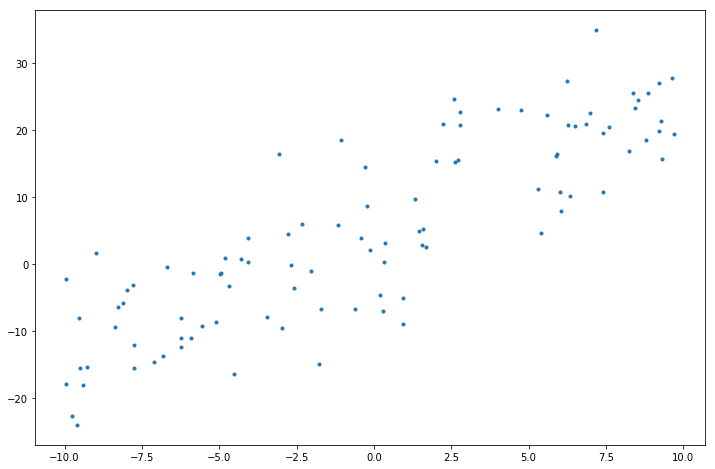

In [4]:
plt.plot(x, y_obs, '.')
plt.show();

## MCMC

The Monte Carlo Markov Chain is an ensemble of methods to sample from a probability distribution. The target distribution is often complex to be sampled directly so we need a different approach. The main idea is to generate lots of random samples (Monte Carlo) with a Markov Chain that eventually converge to the target distribution.

Suppose we have data samples $\mathbf{x} = (x_1, x_2, ..., x_n)$.

We make the hypothesis that observations follow a known statistical law with parameters $\theta=(\theta_1, \theta_2, ..., \theta_p)$

Furthermore, we suppose that each observation is i.i.d.

With a bayesian approach, the parameters $\theta_i$ are considered stochastic variables with a given prior probability density $P(\theta)$. And as in a frequentist approach, we determine a statistical law for the observations $P(\mathbf{x}|\theta)$ (the likelihood).

What we are looking for is the posterior probability density. That's where we can use the powerful Bayes formula

$$P(\theta|\mathbf{x}) = \frac{P(\mathbf{x}|\theta)P(\theta)}{P(\mathbf{x})}$$

The advantage of a bayesian approach is that we don't have a fixed value for the parameters, but we now know their corresponding probability densities, from which we can easily compute confidence intervals, quantiles etc.

Now, what is a Markov Chain ? To make things easy, a Markov Chain is a process where the next state ony depends on the current one, i.e. it a memoryless process. We do not need to know the whole process to predict the next output, an approximation based on the current observation works i.e.

$$P(X_{x+1}|X_i, X_{i-1},...,X_0) = P(X_{x+1}|X_i)$$

Applied to a Monte Carlo simulation, a MCMC is a method to repeatedly sample random values of the regressors ($\theta_i$) knowing their distribution and based on their current value. MCMC then converges to the target distribution.

So the first step is to figure out what the prior distributions are so that we can generate random samples.

Let's start with the intercept. We'll suppose its distribution is simply a gaussian distribution. To estimate its characteristics, we take advantage of the fact that $X$ values are more or less equally distributed around the origin. Taking the mean of $Y$ values can give us an approximation of the true value of the intercept, and the standard deviation its spread.

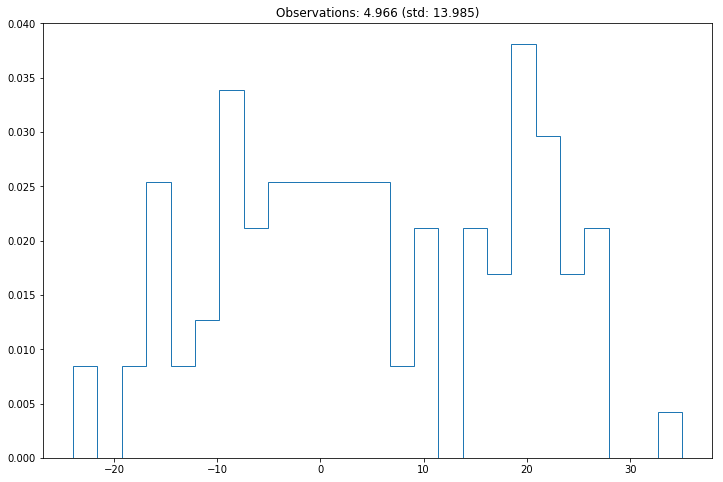

In [5]:
y_mean = np.mean(y_obs)
y_std = np.std(y_obs)

plt.hist(y_obs, bins=25, histtype='step', density=True)
plt.title(f"Observations: {y_mean:.3f} (std: {y_std:.3f})")
plt.show();

With this intercept estimation, we can estimate the slope of our model as follow

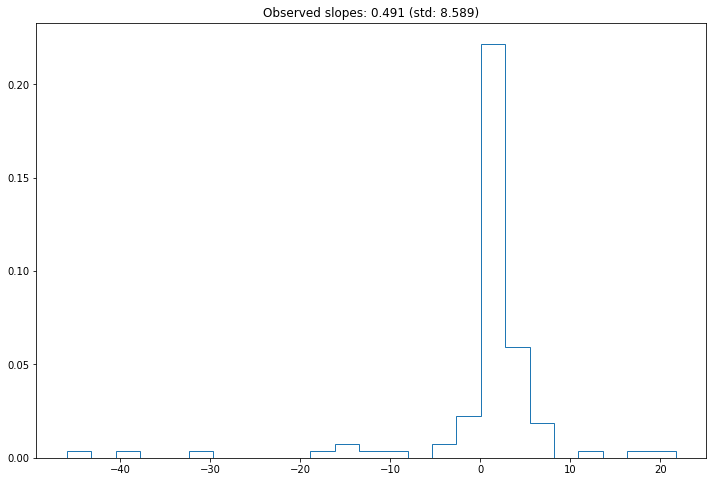

In [6]:
slopes = (y_obs-y_mean)/x
a_mean = np.mean(slopes)
a_std = np.std(slopes)

plt.hist(slopes, bins=25, histtype='step', density=True)
plt.title(f"Observed slopes: {a_mean:.3f} (std: {a_std:.3f})")
plt.show();

The likelihood we choose is then the difference between the model and the true values. The choice of this distribution is mostly an art, but we'll suppose here that this error has a normal distribution. As explained later, we use log densities to avoid numerical issues

In [7]:
def likelihood(y_true, x, slope, intercept, err_std):
    y_pred = intercept + slope * x
    return np.sum(np.log(norm.pdf(y_true, loc=y_pred, scale=err_std)))

Now we define our prior. We've already chosen the densities for the intercept and the slope as normal distributions. For the error, we choose a uniform density. Finally, we take the log densities: as the prior is the product of several probabilities, it can become a very low value which can be unstable numerically.

In [8]:
# slope ~ N(0.5, 9)
# intercept ~ N(5, 14)
# err_std ~ uniform(0, 30)
def prior(slope, intercept, err_std):
    slope_mu = 0.5
    slope_s = 9
    intercept_mu = 5
    intercept_s = 14
    return np.log(norm.pdf(slope, loc=slope_mu, scale=slope_s)) + \
            np.log(norm.pdf(intercept, loc=intercept_mu, scale=intercept_s)) + \
            1/np.sqrt(err_std) + np.log(uniform.pdf(err_std, loc=0, scale=30))

Following the Bayes theorem, the posterior is the simply the sum (log of a product) of the prior and likelihood

In [9]:
def posterior(y_true, x, slope, intercept, err_std):
    return likelihood(y_true, x, slope, intercept, err_std) + prior(slope, intercept, err_std)

Several algorithms exists to sample random variables, but we choose the most commonly used one, the Metropolis Hastings algorithm, which proceeds as follow

Given an initial guess $\theta$ with a positive probability, we choose a new value $\theta_p = \theta + \delta$ where $\delta \sim \mathcal{N}(0,\,\sigma^{2})$

We now compute the acceptance ratio

$$\rho=\frac{h(\mathbf{X}|\theta_p)p(\theta_p)}{h(\mathbf{X}|\theta)p(\theta)}$$

where $h$ is the proposal distribution to the posterior density.

The Metropolis-Hastings tells us to accept the new value of $\theta_p$ with probability $\rho$. Practically, we generate a random sample from a uniform density and compare its value to the ratio $\rho$. If $\rho$ is greater than the sample we accept the new value or $\theta$

In [10]:
N_SAMPLES = 100000
np.random.seed(1000)

# Initialize with random values
slope = norm.rvs(0.5, 9)
intercept = norm.rvs(5, 14)
err_std = uniform.rvs(0, 30)
# Storing vector
samples = np.zeros((N_SAMPLES+1, 3))
samples[0, :] = [slope, intercept, err_std]
# Compute first posterior
prev = posterior(y_obs, x, slope, intercept, err_std)
# Iterate
for i in tqdm_notebook(np.arange(N_SAMPLES)):
    # New samples from the previous ones, not too far. 
    slope_curr = norm.rvs(slope, 0.1)
    intercept_curr = norm.rvs(intercept, 0.1)
    err_std_curr = norm.rvs(err_std, 0.1)
    # Current posterio
    current = posterior(y_obs, x, slope_curr, intercept_curr, err_std_curr)
    # Acceptance ratio
    rho = min(1, np.exp(current - prev))
    # Criteria
    u = uniform.rvs()
    if u < rho:
        slope = slope_curr
        intercept = intercept_curr
        err_std = err_std_curr
        prev = current
    samples[i+1, :] = [slope, intercept, err_std]

We can then plot the resulting distributions for each parameter of the model. Note that we do not take the first samples (burnin samples) to ensure that the Markov Chain already converged towards the target distribution.

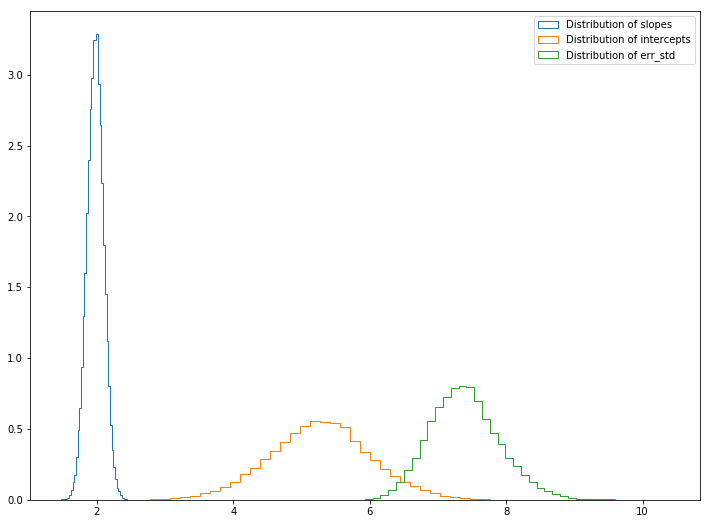

In [11]:
plt.figure(figsize=(12, 9))
burnin = N_SAMPLES // 10
plt.hist(samples[burnin:, 0], 40, histtype='step', density=True, linewidth=1, label='Distribution of slopes');
plt.hist(samples[burnin:, 1], 40, histtype='step', density=True, linewidth=1, label='Distribution of intercepts');
plt.hist(samples[burnin//2:, 2], 40, histtype='step', density=True, linewidth=1, label='Distribution of err_std');
plt.legend(loc='best');

In [12]:
[slope, intercept, err_std] = np.mean(samples[burnin:, :], axis=0)
[slope_std, intercept_std, err_std_std] = np.std(samples[burnin:, :], axis=0)
print(f'slope: {slope:.3f} ({slope_std:.3f})')
print(f'intercept: {intercept:.3f} ({intercept_std:.3f})')
print(f'err_std: {err_std:.3f} ({err_std_std:.3f})')

slope: 1.973 (0.122)
intercept: 5.275 (0.746)
err_std: 7.394 (0.517)


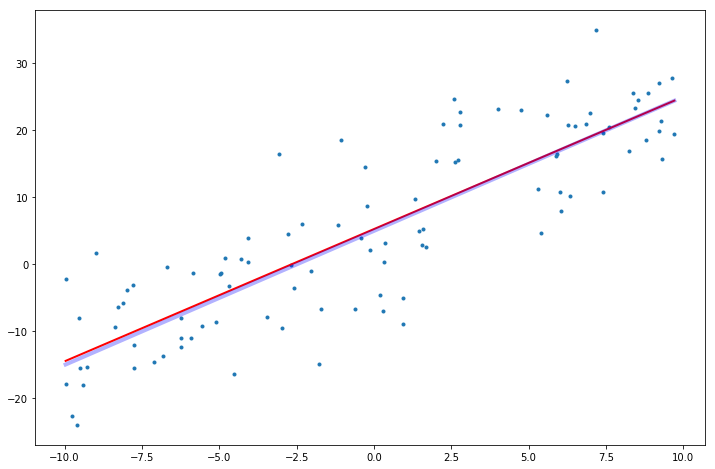

In [13]:
model = slope * x + intercept
plt.plot(x, y_obs, '.')
plt.plot(x, model, 'r', linewidth=2)
plt.plot(x, slope_true * x + intercept_true, 'b', linewidth=4, alpha=0.3)
plt.show();

In [14]:
x_mean  =np.mean(x)
x_std = np.std(x)
confidence = 0.95
n = len(x)
df = n - 3
t_stat = t._ppf((1+confidence)/2., df)
s_y = np.sqrt(np.sum((y_obs-model) ** 2) / df)

interval = t_stat * s_y * np.sqrt(1/n + (x-x_mean)**2 / ((n-1) * x_std**2))
upper = model + interval
lower = model - interval

From here, we can compute the traditional confidence interval

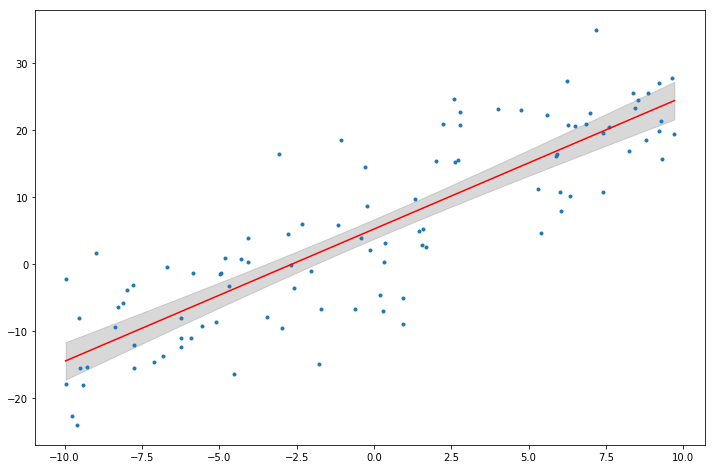

In [15]:
plt.plot(x, y_obs, '.')
plt.plot(x, model, 'r')
plt.fill_between(x, lower, upper, color='0.5', alpha=0.3)
plt.show();

We can also draw several line samples from the computed distributions

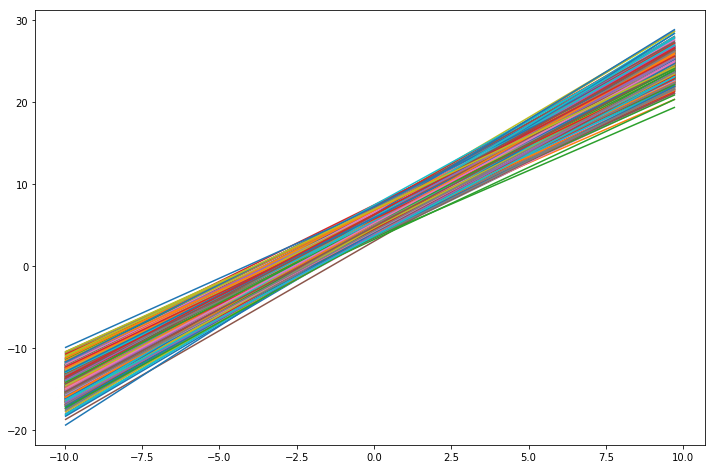

In [16]:
N = 1000
a = norm.rvs(slope, slope_std, N)
b = norm.rvs(intercept, intercept_std, N)
Y = x.reshape(-1, 1) * a + b
X = x.reshape(-1, 1) * np.ones((1, N))
plt.plot(X, Y)
plt.show();

and look at the distribution of the expected values at a given point

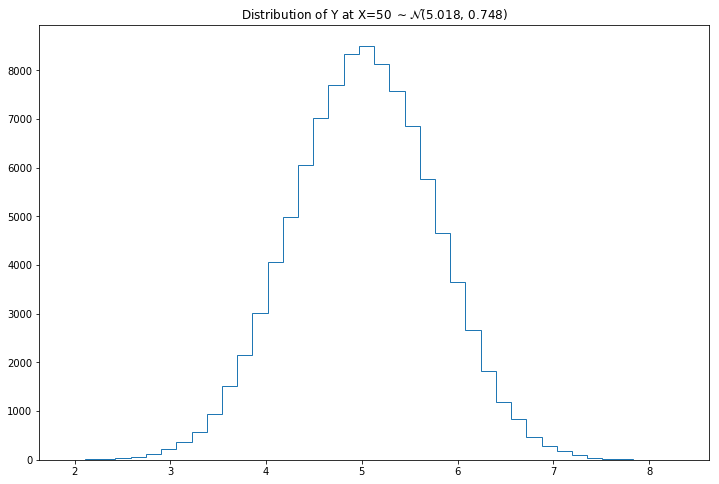

In [17]:
N = 100000
L = len(x)
a = norm.rvs(slope, slope_std, N)
b = norm.rvs(intercept, intercept_std, N)
Y = x.reshape(-1, 1) * a + b
plt.hist(Y[L//2, :], 40, histtype='step')
plt.title(f"Distribution of Y at X={L//2} $\\sim \\mathcal{{N}}({np.mean(Y[L//2, :]):.3f},\\,{np.std(Y[L//2, :]):.3f})$")
plt.show();

# With PyMC3

Now that we have seen how MCMC works with the Metropolis-Hastings sampling algorithm, we can use the robust and powerful package PyMC3 which basically do the same much better, ad much more !

In [18]:
import pymc3 as pm

In [19]:
np.random.seed(100)
model = pm.Model()

with model:
    # Create the alpha and beta parameters and error
    slope = pm.Normal('slope', mu=0.5, sd=9)
    intercept = pm.Normal('intercept', mu=5, sd=14)
    err = pm.Uniform('err', lower=0, upper=30)
    
    # Expected value of outcome (deterministic random variable its value is completely 
    # determined by its parents’ values)
    mu = pm.Deterministic('line', intercept + slope * x)

    # Likelihood (sampling distribution) of observations
    Y_obs = pm.Normal('Y_obs', mu=mu, sd=err, observed=y_obs)
    
    # Using Metropolis Hastings Sampling
    step_algo = pm.Metropolis()
    
    # Sample from the posterior using the sampling method
    trace = pm.sample(N_SAMPLES, step=step_algo, tune=N_SAMPLES//10)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [err_interval__]
>Metropolis: [intercept]
>Metropolis: [slope]
 14%|█▍        | 15912/110000 [00:05<00:33, 2795.49it/s]INFO (theano.gof.compilelock): Waiting for existing lock by process '9719' (I am process '9720')
INFO (theano.gof.compilelock): To manually release the lock, delete /home/guillaume/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.6.5-64/lock_dir
 15%|█▍        | 16205/110000 [00:05<00:33, 2789.68it/s]INFO (theano.gof.compilelock): Waiting for existing lock by process '9719' (I am process '9721')
INFO (theano.gof.compilelock): To manually release the lock, delete /home/guillaume/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.6.5-64/lock_dir
 31%|███       | 33608/110000 [00:11<00:26, 2871.71it/s]INFO (theano.gof.compilelock): Waiting for existing lock by process '9720' (I am process '9721')
INFO (theano.gof.compilelock): To manually release th

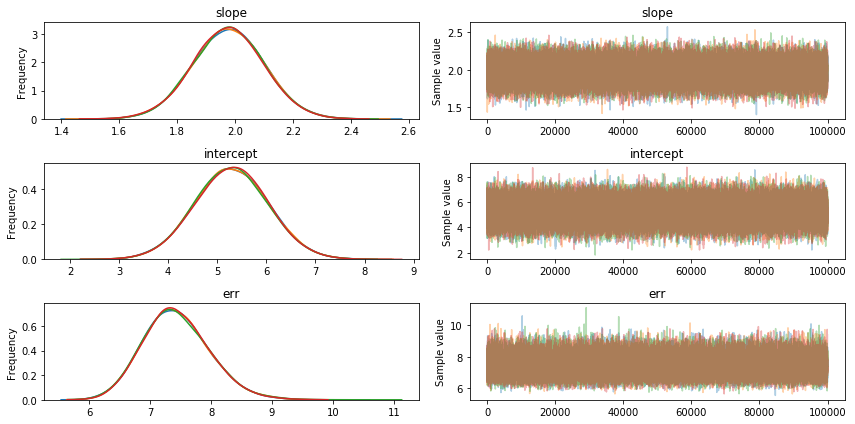

In [20]:
pm.traceplot(trace, varnames=['slope', 'intercept', 'err']);

In [21]:
pm.summary(trace, varnames=['slope', 'intercept', 'err']).round(2)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
slope,1.97,0.12,0.0,1.73,2.22,77568.48,1.0
intercept,5.27,0.74,0.0,3.82,6.74,88697.02,1.0
err,7.42,0.54,0.0,6.39,8.48,74181.16,1.0


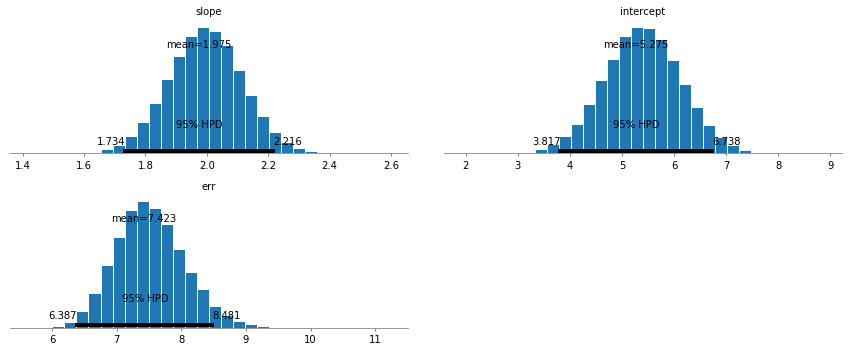

In [22]:
pm.plot_posterior(trace, varnames=['slope', 'intercept', 'err']);

With the computed parameters statistics, we can randomly generate new lines

In [23]:
PP_SAMPLES = 50000
with model:
    pp_trace = pm.sample_ppc(trace, PP_SAMPLES, random_seed=100)

100%|██████████| 50000/50000 [00:18<00:00, 2693.38it/s]


and then compute the credible interval $\left[5\%-95\%\right]$

In [24]:
quantiles = pm.stats.quantiles(pp_trace['Y_obs'], qlist=[5, 95])

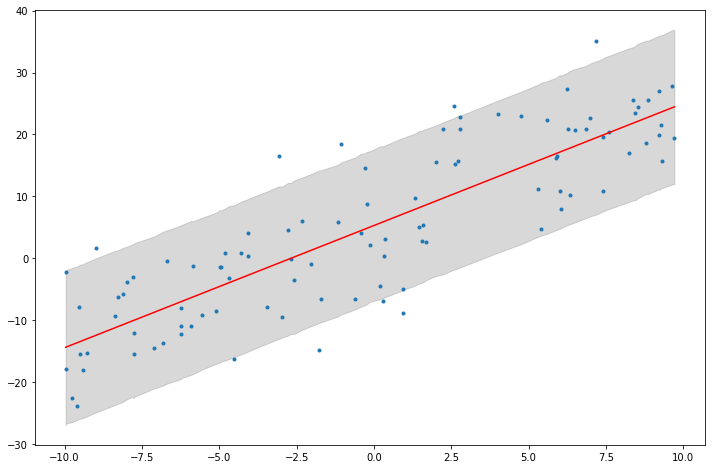

In [25]:
plt.plot(x, y_obs, '.')
plt.plot(x, np.mean(trace['slope']) * x + np.mean(trace['intercept']), 'r')
plt.fill_between(x, quantiles[5], quantiles[95], color='0.5', alpha=0.3)
plt.show();